In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LinearRegression 
from sklearn import metrics
from scipy import stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet

import warnings
warnings.filterwarnings(action="ignore")
%matplotlib inline


In [27]:
# read data
df = pd.read_csv('diamonds.csv', encoding="cp949")
df.head()

,Unnamed,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [28]:
# Delete unnecessary columns
df.drop('Unnamed',axis=1, inplace=True)

In [4]:
# Remove outlier 
z = np.abs(stats.zscore(df._get_numeric_data()))
threshold = 3

df = df[(z < threshold).all(axis=1)]

In [34]:
# Check the missing data
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [29]:
# Function to visualize category data
# Parameters: data, categorical column name, pie (True: draw pie chart, False)
def printCatUnique(data, columnName, pie = False):
    print(data[columnName].unique())
    print("''{0}'' Column Unique count : {1}".format(columnName, len(data[columnName].unique())))
    
    if pie==True:
        data[columnName].value_counts().plot.pie(autopct='%.3f%%', figsize=(7,7))
        plt.title(columnName)
        plt.show()

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
''cut'' Column Unique count : 5


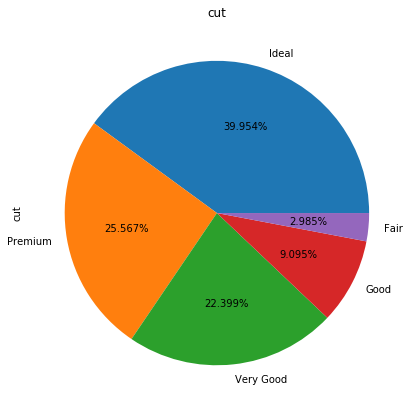

In [30]:
# Check the categorical data 'cut' distribution 
printCatUnique(df[['cut']], 'cut', True)

In [31]:
# Check the categorical data 'color' distribution 
printCatUnique(df[['color']], 'color')

['E' 'I' 'J' 'H' 'F' 'G' 'D']
''color'' Column Unique count : 7


In [32]:
# Check the categorical data 'clarity' distribution 
printCatUnique(df[['clarity']], 'clarity')

['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']
''clarity'' Column Unique count : 8


In [9]:
# One hot encoding catogorical data
one_hot_cut = pd.get_dummies(df['cut'])
df = df.drop(['cut'],axis = 1)
df = df.join(one_hot_cut)

one_hot_color = pd.get_dummies(df['color'])
df = df.drop(['color'],axis = 1)
df = df.join(one_hot_color)

one_hot_clarity = pd.get_dummies(df['clarity'])
df = df.drop(['clarity'],axis = 1)
df = df.join(one_hot_clarity)

In [10]:
df.head()

,carat,depth,table,price,x,y,z,Fair,Good,Ideal,...,I,J,I1,IF,SI1,SI2,VS1,VS2,VVS1,VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0
5,0.24,62.8,57.0,336,3.94,3.96,2.48,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [12]:
X = df.drop(['price'], axis = 1)
y = df['price']

In [13]:
# Scaling data to 0~1
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X)

In [14]:
# Spliting X and y into train and test 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state = 42)

In [15]:
################################## Run ##################################
Result = {'model': ['linear',' ridge','lasso', 'elastic net'], 'RMSE': []}

In [16]:
# evaluate: Visualize the value of y along the x axis

def evaluate (X, y, targetName):
    temp = X
    temp[targetName] = y
    sns.pairplot(temp, x_vars=['table','depth','carat'], y_vars= targetName, size=7, aspect=0.7)

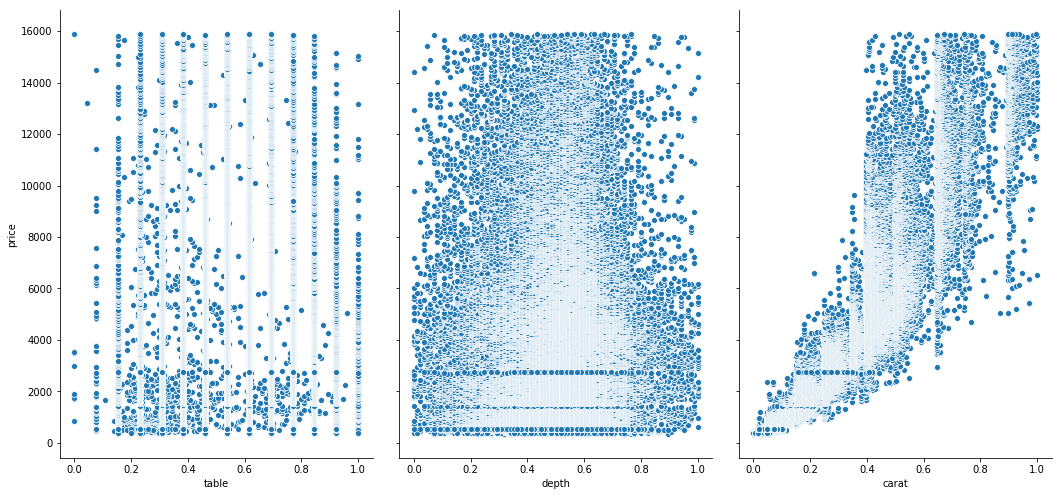

In [17]:
evaluate (X, y, 'price')

In [18]:
# training the model and print accuracy 
# parameters: model, X_train, X_test, y_train, y_test
# return: RMSE score
def getScore (model, X_train, X_test, y_train, y_test):
    # Lambda 
    alpha_params = { 'alpha' : [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 10, 20]}
    grid_reg = GridSearchCV(model, alpha_params, scoring='neg_mean_squared_error', cv=5)
    
    # training the data 
    grid_reg.fit(X_train, y_train)
    y_pred = grid_reg.predict(X_test)
    
    # print best lambda value
    print('Best parameter: ',grid_reg.best_params_)
     
    # get mean squared error and root mean squared error
    mse = metrics.mean_squared_error(y_test, y_pred)
    
    print("MSE:",mse )
    print("RMSE: ", np.sqrt(mse))

    return np.sqrt(mse)


In [19]:
# Model 1: Linear regression
linear = LinearRegression()

# training the data
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

# get mean squared error
mse = metrics.mean_squared_error(y_test, y_pred)
print("MSE:",mse )
print("RMSE: ", np.sqrt(mse))
    
RMSE =  np.sqrt(mse)
Result['RMSE'].append(RMSE)

MSE: 855783.1566841119
RMSE:  925.0854861493136


In [20]:
# Model 2: Ridge regression
ridge = Ridge()
RMSE = getScore (ridge, X_train, X_test, y_train, y_test)
# save the result
Result['RMSE'].append(RMSE)

Best parameter:  {'alpha': 0.01}
MSE: 855621.6281514241
RMSE:  924.9981773773525


In [21]:
# Model 3: Lasso regression
lasso = Lasso()
RMSE = getScore (lasso, X_train, X_test, y_train, y_test)
# save the result
Result['RMSE'].append(RMSE)

Best parameter:  {'alpha': 0.01}
MSE: 855824.1909112135
RMSE:  925.1076644970647


In [22]:
# Model 4: Elastic Net regression
elastic = ElasticNet()
RMSE = getScore (elastic, X_train, X_test, y_train, y_test)
# save the result
Result['RMSE'].append(RMSE)

Best parameter:  {'alpha': 1e-08}
MSE: 855671.3741414913
RMSE:  925.0250667638641


In [23]:
# print the final result 
Result

{'model': ['linear', ' ridge', 'lasso', 'elastic net'],
 'RMSE': [925.0854861493136,
  924.9981773773525,
  925.1076644970647,
  925.0250667638641]}

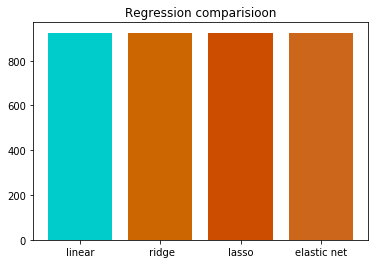

In [24]:
# visualize the results
plt.title ('Regression comparisioon')
plt.bar(Result['model'], Result['RMSE'], color = [(0,0.8,0.8), (0.8,0.4,0),(0.8,0.3,0), (0.8,0.4,0.1)])
plt.show()